In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils
import pickle
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
filename = 'data/forAbhi/Velocity_MeanSEM.mat'
data = scipy.io.loadmat(filename)
T4_arclight_mean = data['Arcmean']
T4_arclight_sem = data['ArcSE']

T4_gcamp_mean = data['Gmean']
T4_gcamp_sem = data['GSE']

In [113]:
def calc_peaktuning(data_list, sem_list, speed, contrast =False):
    peak_tuning = np.empty((len(data_list),len(speed),12)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for 12 directions
    peak_tuning_sem = np.empty((len(sem_list),len(speed),12))
    for j in range(len(data_list)):
        for i in range(4):
            rowindex = data_list[j][:,i:48+i:4].argmax(axis=0)
            colindex = np.arange(i,48+i,4)
            peak_tuning[j,i,:] = data_list[j][:,i:48+i:4].max(axis=0)
            peak_tuning_sem[j,i,:] = sem_list[j][rowindex,colindex]
    arc_max = peak_tuning[0].max()
    gcamp_max = peak_tuning[1].max()
    peak_tuning[0] = peak_tuning[0] / arc_max
    peak_tuning_sem[0] = peak_tuning_sem[0] / arc_max
    peak_tuning[1] = peak_tuning[1] / gcamp_max
    peak_tuning_sem[1] = peak_tuning_sem[1] / gcamp_max
    if contrast == True:
        peak_tuning = peak_tuning[:,::-1,:]
        peak_tuning_sem = peak_tuning_sem[:,::-1,:]
        
    return peak_tuning, peak_tuning_sem

In [114]:
def plot_oripeaktuning(data_list, sem_list, speed, color, ylim1=(0,0.08),ylim2=(0,2.5), fig_size=(15,10), title='',savefig=False, contrast = False):
    peak_tuning, peak_tuning_sem = calc_peaktuning(data_list, sem_list, speed, contrast)

            
    def polar_plot(data, data_sem, rotations_rad, ax, ylim,marker='o', color='r',label=''):
        data = np.append(data, data[0])
        data_sem = np.append(data_sem, data_sem[0])
        ax.plot(rotations_rad, data, marker=marker, markersize=3.0,color=color,label=label,linewidth=2.0)
        ax.fill_between(rotations_rad, data-data_sem, data+data_sem, color=color,alpha=0.3)
        #ax.set_facecolor('#d3d3d3')
        ax.set_facecolor((0.9,0.9,0.9,0.7))
        #ax.plot(rotations_rad, data, color=color, label=label,linewidth=2.0)
        ax.set_ylim(ylim)
        
    rotations = np.arange(0.0,390.0,30.0)
    rotations_rad = (rotations * np.pi) / 180
    fig, ax = plt.subplots(1,4,subplot_kw={'projection': 'polar'}, figsize=fig_size)
    for i in range(4):
        polar_plot(peak_tuning[0,i,:], peak_tuning_sem[0,i,:],rotations_rad, ax[i], ylim=ylim1,color='k',label='Arclight' );
        polar_plot(peak_tuning[1,i,:], peak_tuning_sem[1,i,:],rotations_rad, ax[i], ylim=ylim2,color='r',label='GCaMP' );
          
        
#     for j in range(2):
#         for i in range(4):
#             if j == 1:
#                 polar_plot(peak_tuning[1,i,:], rotations_rad, ax[1][i], ylim=ylim2,color='r',label='GCaMP' );
#                 #polar_plot(peak_tuning[2,i,:], rotations_rad, ax[1][i], ylim=(0,225),color='r' );
#             if j == 0:
#                 polar_plot(peak_tuning[0,i,:], rotations_rad, ax[0][i], ylim=ylim1,color='k',label='Arclight' );
    ax[3].legend(loc=1, bbox_to_anchor=(0,0,1,1.15),frameon=False);
    #ax[3].legend(loc=1, bbox_to_anchor=(0,0,1,1.1),frameon=False);
                
    row = ['Arclight','GCaMP']
    
    for axis,s in zip(ax,speed):
        if contrast == True:
            axis.set_title(str(s)+'%',fontsize=12, pad=20);
        else:
            axis.set_title(str(s)+' deg/s',fontsize=12, pad=20);
        
    plt.subplots_adjust()
    plt.tight_layout();
    #ax[1][0].arrow(0,0,angle_rad, mag*200)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
    
def calc_Ldir(peak_tuning):
    Ldir_array = np.empty((peak_tuning.shape[0],peak_tuning.shape[1],2)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for angle and magnitude
    def Ldir(data):
        rot = np.arange(0.0,360.0,30.0)
        rot_rad = (rot*np.pi)/180
        data_x = np.sum(data*np.cos(rot_rad))
        data_y = np.sum(data*np.sin(rot_rad))
        angle_rad = np.arctan(data_y/data_x)
        if angle_rad <0.0:
            angle_rad = angle_rad+np.pi
        mag = np.sqrt(data_y**2 + data_x**2) / np.sum(data)
        return (angle_rad, mag)
    
    for j in range(peak_tuning.shape[0]):
        for i in range(peak_tuning.shape[1]):
            Ldir_array[j,i,:] = Ldir(peak_tuning[j,i,:])
    Ldir_array = np.nan_to_num(Ldir_array)
    
    return Ldir_array

def plot_Ldir_mag(peak_tuning,speed=[15,30,60,120],title='',savefig=False,contrast=False):
    Ldir = calc_Ldir(peak_tuning)
    Ldir_mag = Ldir[:,:,1]
    f, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(4,4))
    #ax.plot(Ldir_mag[1]);
    n = len(speed)
    ax.plot(Ldir_mag[0],marker='o',color='k',label='Arclight');
    ax.plot(Ldir_mag[1],marker='o',color='red',label='GCaMP');
    ax.legend(loc=0,frameon=False);
    ax.set_title('Ldir')
    ax.set_ylim(0.0,1.0);
    if contrast == True:
        ax.set_xlabel('Contrast(%)',fontsize=12)
    else :
        ax.set_xlabel('Speed(deg/s)',fontsize=12)
    plt.xticks(range(0,n),speed); 
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_Ldir(peak_tuning,fig_size=(15,4), title='',savefig=False):
    Ldir_array = np.empty((peak_tuning.shape[0],peak_tuning.shape[1],2)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for angle and magnitude
    def Ldir(data):
        rot = np.arange(0.0,360.0,30.0)
        rot_rad = (rot*np.pi)/180
        data_x = np.sum(data*np.cos(rot_rad))
        data_y = np.sum(data*np.sin(rot_rad))
        angle_rad = np.arctan(data_y/data_x)
        if angle_rad <0.0:
            angle_rad = angle_rad+np.pi
        mag = np.sqrt(data_y**2 + data_x**2) / np.sum(data)
        return (angle_rad, mag)
    
    for j in range(peak_tuning.shape[0]):
        for i in range(peak_tuning.shape[1]):
            Ldir_array[j,i,:] = Ldir(peak_tuning[j,i,:])
    Ldir_array = np.nan_to_num(Ldir_array)
    
    fig, ax = plt.subplots(1,4,subplot_kw={'projection': 'polar'}, figsize=fig_size)
    for i in range(4):
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[0,i,0],Ldir_array[0,i,1]),arrowprops=dict(facecolor='black'))
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[1,i,0],Ldir_array[1,i,1]),
                       arrowprops=dict(facecolor='blue'))
        #ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[2,i,0],Ldir_array[2,i,1]),arrowprops=dict(facecolor='red'))
    ax[0].set_ylabel('Ldir', rotation=0,fontsize=12, labelpad=60);
    plt.tight_layout();    
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

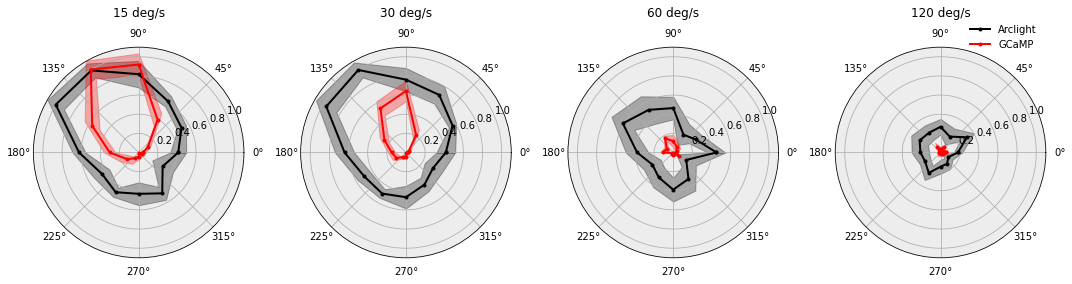

In [115]:
data_list = [T4_arclight_mean, T4_gcamp_mean]
sem_list = [T4_arclight_sem, T4_gcamp_sem]
velocity = [15, 30, 60, 120]
peak_tuning, peak_tuning_sem = calc_peaktuning(data_list,sem_list, speed=velocity)
plot_oripeaktuning(data_list,sem_list, speed=velocity, fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['k','r'],title='Speed_Ori_Tuning',savefig=True);

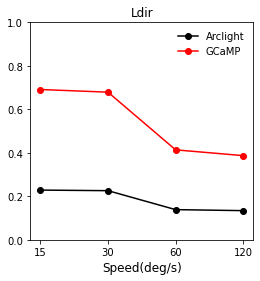

In [127]:
plot_Ldir_mag(peak_tuning, title='Ldir_Speed_Ori_Tuning',savefig=True);

In [128]:
filename = 'data/forAbhi/Contrast_MeanSEM.mat'
data = scipy.io.loadmat(filename)
T4_arclight_mean = data['Arcmean']
T4_arclight_sem = data['ArcSE']

T4_gcamp_mean = data['Gmean']
T4_gcamp_sem = data['GSE']

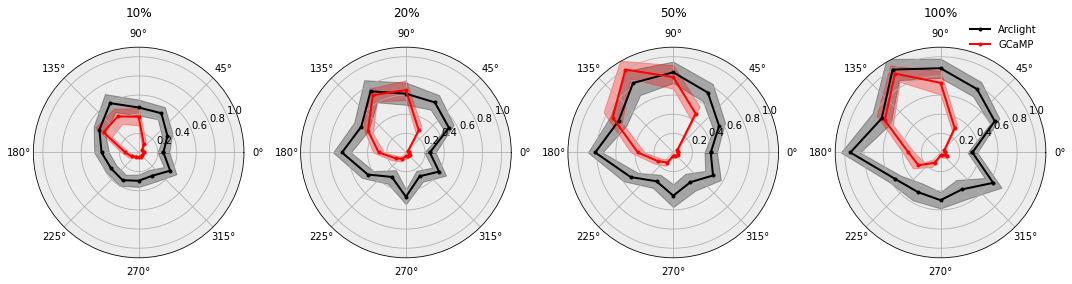

In [129]:
data_list = [T4_arclight_mean, T4_gcamp_mean]
sem_list = [T4_arclight_sem, T4_gcamp_sem]
contrast = [10, 20, 50, 100]
peak_tuning, peak_tuning_sem = calc_peaktuning(data_list,sem_list, speed=contrast, contrast=True)
plot_oripeaktuning(data_list,sem_list, speed=contrast, contrast=True,fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['k','r'],title='Contrast_Ori_Tuning',savefig=True);

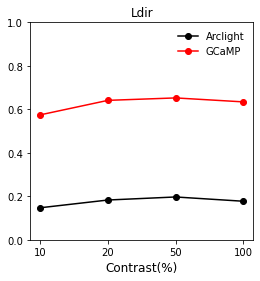

In [130]:
plot_Ldir_mag(peak_tuning,speed=contrast, title='Ldir_Contrast_Ori_Tuning',savefig=True,contrast=True);

In [131]:
0.06/0.07

0.857142857142857

In [132]:
0.03/0.07

0.4285714285714285